In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.02

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes, xlim=[], ylim=[]):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = [[] for _ in range(len(scenes))]
        self.adding_lines = False
        self.added_lines = [[] for _ in range(len(scenes))]
        self.adding_rects = False
        self.added_rects = [[] for _ in range(len(scenes))]
        # DODANO: zapisz tytuł sceny
        self.scene_title = self.scenes[0].title if len(self.scenes) and self.scenes[0].title else ""
        # DODANO: ustawienie zakresów osi wykresu
        self.xlim = xlim
        self.ylim = ylim
        self.custom_axis = len(xlim) != 0 or len(ylim) != 0

    def set_axes(self, ax):
        self.ax = ax
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        # ADDED: Change scene title
        self.scene_title = self.scenes[self.i].title
        self.draw(autoscaling = not self.custom_axis)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        # ADDED: Change scene title
        self.scene_title = self.scenes[self.i].title
        self.draw(autoscaling = not self.custom_axis)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points[self.i].append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines[self.i].append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects[self.i].append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        return self.added_points[self.i]
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        return self.added_lines[self.i]
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        return self.added_rects[self.i]
  
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        return Scene(self.added_points[self.i], self.added_lines[self.i]+self.added_rects[self.i])


    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[self.i][-1].add_points([new_point])
            self.draw(autoscaling = False,hand_drawing=True)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[self.i][-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False,hand_drawing=True)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[self.i][-1].add((self.rect_points[-1], new_point))
                self.rect_points.append(new_point)
                self.draw(autoscaling = False,hand_drawing=True)
            elif len(self.rect_points) > 1:
                # DODANO: zmiana metody wykrywania zakończenia figury.
                # Teraz punkt self.rect_points[0] jest środkiem okręgu o promieniu TOLERANCE*(mediana zakresów wykresu)
                # Gdy użytkownik kliknie w obrębie tego okręgu, figura zostanie zamknięta
                if (new_point[0] - self.rect_points[0][0]) ** 2 + (new_point[1] - self.rect_points[0][1]) ** 2 <= (np.mean([self.ax.get_xlim()[1] - self.ax.get_xlim()[0], self.ax.get_ylim()[1]-self.ax.get_ylim()[0]])*TOLERANCE) ** 2:
                    self.added_rects[self.i][-1].add((self.rect_points[-1], self.rect_points[0]))
                    self.new_rect()
                else:    
                    self.added_rects[self.i][-1].add((self.rect_points[-1], new_point))
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False, hand_drawing=True)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True, hand_drawing = False):
        # DODANO: ustawienie zakresów osi wykresu
        autoscale_axis='both'
        if not autoscaling:
            if self.custom_axis:
                xlim = self.xlim  
                ylim = self.ylim  

            choose_autoscale_axis = [False, False] # [OX, OY]

            if not self.custom_axis or not self.xlim:
                xlim = self.ax.get_xlim()
                choose_autoscale_axis[0] = True
            
            if not self.custom_axis or not self.ylim:
                ylim = self.ax.get_ylim()
                choose_autoscale_axis[1] = True

            if choose_autoscale_axis == [True, False]:
                autoscale_axis = 'x'
                autoscaling = not hand_drawing
            if choose_autoscale_axis == [False, True]:
                autoscale_axis = 'y'
                autoscaling = not hand_drawing

        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points[self.i]):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs, zorder=3)
        for collection in (self.scenes[self.i].lines + self.added_lines[self.i] + self.added_rects[self.i]):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(enable=autoscaling, axis=autoscale_axis)

        if autoscale_axis == 'y':
            self.ax.set_xlim(xlim)

        if autoscale_axis == 'x':
            self.ax.set_ylim(ylim)
      
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
            
        # DODANO: tytuł sceny
        fig = plt.gcf() # Pobierz aktywne okno
        fig.suptitle(self.scene_title)
        
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[], title=""):
        self.points=points
        self.lines=lines
        # ADDED: Scene title
        self.title = '\n'+title if title != "" else ""

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [], points = [], lines = [], json = None, title="", xlim=[], ylim=[]):
        # DODANO: tytuł wykresu
        self.plot_title = title
        # DODANO: ustawienie zakresów osi wykresu
        self.xlim = xlim
        self.ylim = ylim
        self.is_not_custom_axis = len(xlim)==0 and len(ylim)==0

        # NAPRAWIONO: pobieranie scen z wcześniej utworzonego wykresu
        if not scenes:
            self.scenes = [Scene()]
        else:
            self.scenes = scenes

        if json is None:
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]], title=scene["title"]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines],
                          "title": scene.title[1:]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            result = self.callback.get_added_points()
            return result
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            result = self.callback.get_added_lines()
            return result

    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            result = self.callback.get_added_figure()
            return result

    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            result = self.callback.get_added_elements()
            return result

    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        # DODANO: tytuł wykresu
        fig = plt.figure(num=self.plot_title)
        # DODANO: ustawienie zakresów osi wykresu
        self.callback = _Button_callback(self.scenes, self.xlim, self.ylim)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        # DODANO: ustawienie zakresów osi wykresu
        self.callback.draw(self.is_not_custom_axis)

In [3]:
import random

## Wyznaczanie odcinków interaktywnie

In [4]:
def getLinesFromPlot(plot):
    lines_class = plot.get_added_lines()
    result = []
    lines = []
    for line_class in lines_class:
        result.append(line_class.lines)
    
    for tab in result:
        if len(tab) != 0:
            lines = tab
        
    return lines

## Generowanie losowych odcinków

In [5]:
def generateRandom(boundary):
    return random.uniform(boundary[0],boundary[1])

def generateLines(boundary, amount, epsilon = 10e-12):

    lines = []

    for _ in range(amount):

        guard = 0
        p = [generateRandom(boundary) for _ in range(4)] # p[0] = x1, p[1] = y1, p[2] = x2, p[3] = y2

        while abs(p[0] - p[2]) < epsilon:
            print("Ok")
            p[2] = generateRandom(boundary)
            guard += 1
            if guard == 100:
                print("Cannot make a correct line")
                return
        lines.append([(p[0], p[1]), (p[2], p[3])])
    
    return lines      

<IPython.core.display.Javascript object>


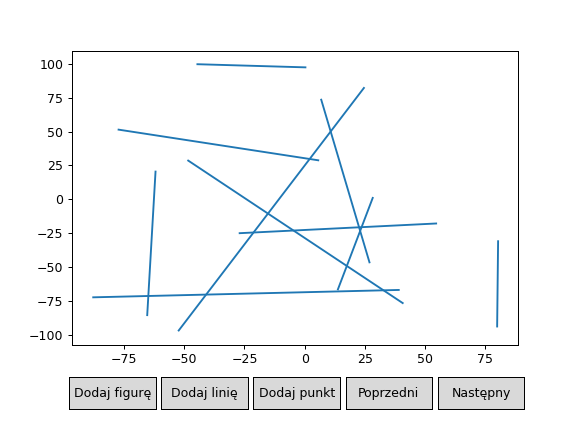

In [6]:
lines = generateLines([-100,100], 10)
lines3 = lines.copy()
plot = Plot(lines = [LinesCollection(lines)])
plot.draw()

## Zapisywanie i odczytywanie odcinków 

In [7]:
def saveToFile(plot, id_of_lines):
    with open('savedLines '+ id_of_lines + '.json', 'w') as file:
        file.write(plot.toJson())

In [8]:
saveToFile(plot, '2')

In [9]:
def readFromFile(name_of_file):
    with open(name_of_file+'.json', 'r') as file:
        json = file.read()
    return json

<IPython.core.display.Javascript object>


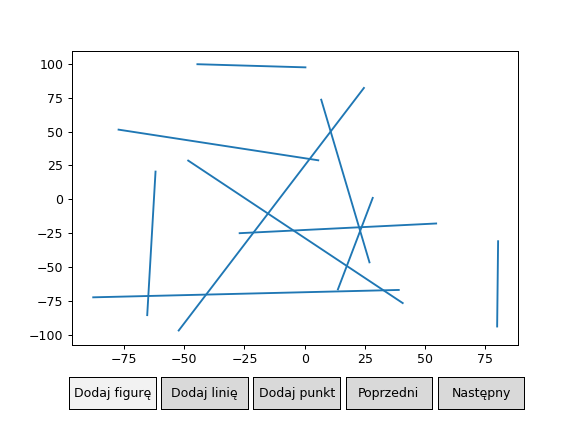

In [10]:
json1 = readFromFile('savedLines 2')
plot1 = Plot(json=json1)
plot1.draw()

## Sprawdzanie czy choć jedna para odcinków się przecina

### Wyznaczanie relacji porównania dwóch odcinków

In [11]:
def direction(pi, pj, pk):
    line1 = (pk[0]-pi[0], pk[1]-pi[1])
    line2 = (pj[0]-pi[0], pj[1]-pi[1])

    x1, y1 = line1
    x2, y2 = line2

    return (x1*y2) - (x2*y1)

def onSegment(pi, pj, pk): # edge case when any point is placed on line
    xi, yi = pi
    xj, yj = pj
    xk, yk = pk

    if min(xi, xj) <= xk <= max(xi, xj) and min(yi, yj) <= yk <= max(yi, yj):
        return True
    return False

def segmentsIntersection(line1, line2, epsilon = 10e-12):
    p1, p2 = line1
    p3, p4 = line2
    
    d1 = direction(p3, p4, p1)
    d2 = direction(p3, p4, p2)
    d3 = direction(p1, p2, p3)
    d4 = direction(p1, p2, p4)

    if ((d1 > epsilon and d2 < -epsilon) or (d1 < -epsilon and d2 > epsilon)) and \
        ((d3 > epsilon and d4 < -epsilon) or (d3 < -epsilon and d4 > epsilon)):
        return True
    elif (abs(d1) < epsilon) and onSegment(p3, p4, p1):
        return True
    elif (abs(d2) < epsilon) and onSegment(p3, p4, p2):
        return True
    elif (abs(d3) < epsilon) and onSegment(p1, p2, p3):
        return True
    elif (abs(d4) < epsilon) and onSegment(p1, p2, p4):
        return True
    else: return False

def compareRelation(line, point, epsilon = 10e-12): # to check if line_s that include point is below line
    p, r = line
    q = point
   
    return ((p[0] - r[0])*(q[1] - r[1]) - (p[1] - r[1])*(q[0] - r[0]))
    



### Drzewo czerwono-czarne

In [12]:
BLACK = 0
RED = 1

class Node():
    def __init__(self, val):
        self.color = RED
        self.p = None
        self.right = None
        self.left = None
        self.val = val

class RBTree(object):
    epsilon = 10e-12
    def __init__(self):
        self.n = 0
        self.Nil = Node((0,0))
        self.Nil.color = BLACK
        self.Nil.left = None
        self.Nil.right = None # it will be pointing self.Nil = its leaf of tree - the leaf points root - parent of root is None
        self.root = self.Nil
        # self.tab = []
    
    def leftRotate(self, x):
        y = x.right
        x.right = y.left
        if y.left != self.Nil:
            y.left.p = x
        y.p = x.p
        if x.p == None:
            self.root = y           
        elif x == x.p.left:
            x.p.left = y
        else:
            x.p.left = y
        y.left = x
        x.p = y
    
    def rightRotate(self, x):
        y = x.left
        x.left = y.right
        if y.right != self.Nil:
            y.right.p = x
        y.p = x.p
        if x.p == None:
            self.root = y
        elif x == x.p.right:
            x.p.right = y
        else:
            x.p.left = y
        y.right = x
        x.p = y
    
    def insertNode(self, key, func): # key = line = ((x1, y1), (x2, y2)) -  we are comparing with y1 = key[0][1]
        self.n += 1
        node = Node(key)
        node.p = None
        node.val
        node.right = self.Nil
        node.left = self.Nil
        node.color = RED
        # self.tab.append(node)

        y = None
        x = self.root

        while x != self.Nil:
            y = x
            # if compareRelation(x.val, key[0]) < -self.epsilon:
            # if x.val[0][1] > key[0][1]:
            if func(x.val, key):
                x = x.left
            else:
                x = x.right
        node.p = y
        if y == None:
            self.root = node
        # elif compareRelation(y.val, key[0]) < -self.epsilon:
        # elif y.val[0][1] > key[0][1]:
        elif func(y.val, key):
            y.left = node
        else:
            y.right = node
        
        if node.p == None:
            node.color = BLACK
            return
        
        if node.p.p == None:
            return
        
        self.insertFixup(node)
        
    def insertFixup(self, z):
        while z.p.color == RED:
            if z.p == z.p.p.left:
                y = z.p.p.right
                if y.color == RED:
                    z.p.color = BLACK
                    y.color = BLACK
                    z.p.p.color = RED
                    z = z.p.p
                else:
                    if z == z.p.right:
                        z = z.p
                        self.leftRotate(z)
                    z.p.color = BLACK
                    z.p.p.color = RED
                    self.rightRotate(z.p.p)
            else:
                y = z.p.p.left
                if y.color == RED:
                    z.p.color = BLACK
                    y.color = BLACK
                    z.p.p.color = RED
                    z = z.p.p
                else:
                    if z == z.p.left:
                        z = z.p
                        self.rightRotate(z)
                    z.p.color = BLACK
                    z.p.p.color = RED
                    self.leftRotate(z.p.p)
            if z == self.root:
                break
        self.root.color = BLACK

    def __transplant(self, u, v):
        if u.p == None:
            self.root = v
        elif u == u.p.left:
            u.p.left = v
        else:
            u.p.right = v
        v.p = u.p

    def deleteNode(self, z):
        # print("z",z)
        # print("tan",self.tab)
        # self.tab.remove(z)
        self.n -= 1
        y = z
        y_org_color = y.color
        if z.left == self.Nil:
            x = z.right
            self.__transplant(z, z.right)
        elif z.right == self.Nil:
            x = z.left
            self.__transplant(z, z.left)
        else:
            y = self.treeMinimum(z.right)
            y_org_color = y.color
            x = y.right
            if y.p == z:
                x.p = y
            else:
                self.__transplant(y, y.right)
                y.right = z.right
                y.right.p = y
            self.__transplant(z, y)
            y.left = z.left
            y.left.p = y
            y.color = z.color
        if y_org_color == BLACK:
            self.deleteFixup(x)

    def treeMinimum(self, x):
        while x.left != self.Nil:
            x = x.left
        return x
    
    def treeMaximum(self, x):
        while x.right != self.Nil:
            x = x.right
        return x

    def deleteFixup(self, x):
        while x != self.root and x.color == BLACK:
            if x == x.p.left:
                w = x.p.right
                if w.color == RED:
                    w.color = BLACK
                    x.p.color = RED
                    self.leftRotate(x.p)
                    w = x.p.right
                if w.left.color == BLACK and w.right.color == BLACK:
                    w.color = RED
                    x = x.p
                else:
                    if w.right.color == BLACK:
                        w.left.color = BLACK
                        w.color = RED
                        self.rightRotate(w)
                        w = x.p.right
                    w.color = x.p.color
                    x.p.color = BLACK
                    w.right.color = BLACK
                    self.leftRotate(x.p)
                    x = self.root
            else:
                w = x.p.left
                if w.color == RED:
                    w.color = BLACK
                    x.p.color = RED
                    self.rightRotate(x.p)
                    w = x.p.left
                if w.right.color == BLACK and w.left.color == BLACK:
                    w.color = RED
                    x = x.p
                else:
                    if w.left.color == BLACK:
                        w.right.color = BLACK
                        w.color = RED
                        self.leftRotate(w)
                        w = x.p.left
                    w.color = x.p.color
                    x.p.color = BLACK
                    w.left.color = BLACK
                    self.rightRotate(x.p)
                    x = self.root
        x.color = BLACK

    def succRBTree(self, x):
        if x.right != self.Nil:
            return self.treeMinimum(x.right)
        y = x.p
        while y != None and x == y.right:
            x = y
            y = y.p
        return y

    def predRBTree(self, x):
        if x.left != self.Nil:
            return self.treeMaximum(x.left)
        y = x.p

        while y != None and x == y.left:
            x = y
            y = y.p
        return y

    def treeSearch(self, x, k, func1, func2):
        # while x != self.Nil and abs(compareRelation(x.val, k)) > self.epsilon:
        # while x != self.Nil and not (x.val[0][1] == k[0][1]):
        while x != self.Nil and not func2(x.val, k):

            # if compareRelation(x.val, k[0]) < -self.epsilon:
            # if x.val[0][1] > k[0][1]:
            if func1(x.val, k):
                x = x.left
            else:
                x = x.right
        return x
    
    def inorderTreeWalk(self, x):
        if x != self.Nil:
            print(x.val)
            # print("LEFT")
            self.inorderTreeWalk(x.left)
            # print("RIGHT")
            self.inorderTreeWalk(x.right)

### Czy jakiekolwiek odcinki się przecinają

In [15]:
def findMaxAndMin(lines):
    min_curr = (0,float('inf'))
    max_curr = (0,float('-inf'))
    for line in lines:
        p = max(line, key=lambda x : x[1])
        if p[1] > max_curr[1]:
            max_curr = p
            
        q = min(line, key=lambda x : x[1])
        if q[1] < min_curr[1]:
            min_curr = q

    return [list(min_curr), list(max_curr)]

def compareFunc1(a, b):
    if a[0][1] > b[0][1]: return True
    return False

def compareFunc2(a, b):
    if a[0][1] == b[0][1]: return True
    return False

def findPoint(line1, line2):
    (p1, q1), (p2, q2) = line1
    (p3, q3), (p4, q4) = line2

    a1 = (q2 - q1) / (p2 - p1)
    b1 = q1 - a1 * p1

    a2 = (q4 - q3) / (p4 - p3)
    b2 = q3 - a2 * p3

    x = (b2 - b1) / (a1 - a2)
    y = a1 * x + b1

    return (x, y)
    

def anySegmentsIntersect(S):
    lines = []
    scenes = []
    copy_lines = S.copy()
    # print(copy_lines)
    lines_in_tree = []
    succ_line = []
    pred_line = []
    broom = findMaxAndMin(S) # line that build broom - visualization
    

    for line in S:
        if line[0][0] < line[1][0]:
            lines.append((line[0][0], line))
            lines.append((line[1][0], line))
        else:
            lines.append((line[0][0], (line[1], line[0])))
            lines.append((line[1][0], (line[1], line[0])))
    

    lines = sorted(lines, key=lambda x : (x[0]))

    T = RBTree()
    for line in lines:
        succ_line = []
        pred_line = []
#         print(line)
        if line[0] == line[1][0][0]:
            T.insertNode(list(line[1]), compareFunc1)
            x = T.treeSearch(T.root, line[1], compareFunc1, compareFunc2)
            x_succ = T.succRBTree(x)
            x_pred = T.predRBTree(x)

            if x_succ is not None:
                succ_line.append(x_succ.val)
            if x_pred is not None:
                pred_line.append(x_pred.val)
            
            scenes.append( Scene(points = [PointsCollection([line[1][0]], color = "cyan")], lines = [LinesCollection(copy_lines), 
                                                                                LinesCollection(succ_line, color = "green"),
                                                                                LinesCollection(pred_line, color = "green"),
                                                                                LinesCollection([x.val], color = 'black'),
                                                                                LinesCollection([[(line[0],broom[0][1]), (line[0],broom[1][1])]], color = "red")]))

            if (x_succ != None and segmentsIntersection(x.val, x_succ.val)):

                scenes.append(Scene(points = [PointsCollection([findPoint(x.val, x_succ.val)], color = "red")], lines = [LinesCollection(copy_lines),
                                                                                                      LinesCollection([x.val], color = "green"),
                                                                                                      LinesCollection(succ_line, color = "green")]))
                print(findPoint(x.val, x_succ.val))
                return (True, scenes)
            if (x_pred != None and segmentsIntersection(x.val, x_pred.val)):
                
                scenes.append(Scene(points = [PointsCollection([findPoint(x.val, x_pred.val)], color = "red")], lines = [LinesCollection(copy_lines),
                                                                                                      LinesCollection([x.val], color = "green"),
                                                                                                      LinesCollection(pred_line, color = "green")]))
                print(findPoint(x.val, x_pred.val))
                return (True, scenes)
        else:
            x = T.treeSearch(T.root, line[1], compareFunc1, compareFunc2)
            x_succ = T.succRBTree(x)
            x_pred = T.predRBTree(x)

            if x_succ is not None:
                succ_line.append(x_succ.val)
            if x_pred is not None:
                pred_line.append(x_pred.val)

            scenes.append( Scene(points = [PointsCollection([line[1][1]], color = "cyan")],lines = [LinesCollection(copy_lines), 
                                                                                LinesCollection(succ_line, color = "green"),
                                                                                LinesCollection(pred_line, color = "green"),
                                                                                LinesCollection([x.val], color = 'black'),
                                                                                LinesCollection([[(line[0],broom[0][1]), (line[0],broom[1][1])]], color = "red")]))


            if x_succ != None and x_pred != None \
                and segmentsIntersection(x_succ.val, x_pred.val):

                scenes.append(Scene(points = [PointsCollection([findPoint(x_succ.val, x_pred.val)], color = "red")], lines=[LinesCollection(copy_lines),
                                                                                                      LinesCollection(succ_line, color = "green"),
                                                                                                      LinesCollection(pred_line, color = "green")]))

                print(findPoint(x_succ.val, x_pred.val))
                return (True, scenes)
            T.deleteNode(x)
    return (False, scenes)



    

(-64.93485937981492, -71.50454373457478)
True


<IPython.core.display.Javascript object>


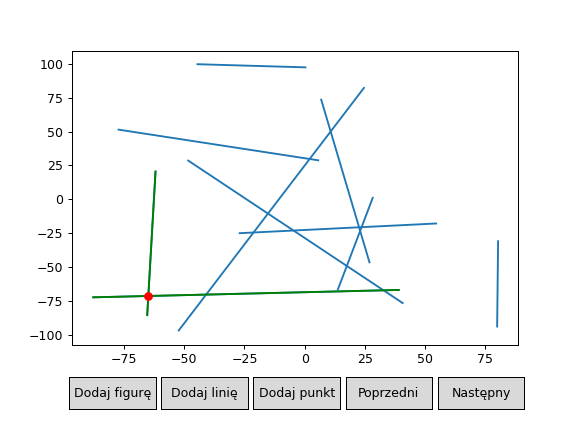

In [16]:
# print(compareRelation([(-94.39724326422103, -72.92792605813956), (74.77997130944863, 97.62323920095284), 0], -94.39724326422103))
ifPoint1, scenes1 = anySegmentsIntersect(lines)
print(ifPoint1)
plot3 = Plot(scenes = scenes1)
plot3.draw()

<IPython.core.display.Javascript object>


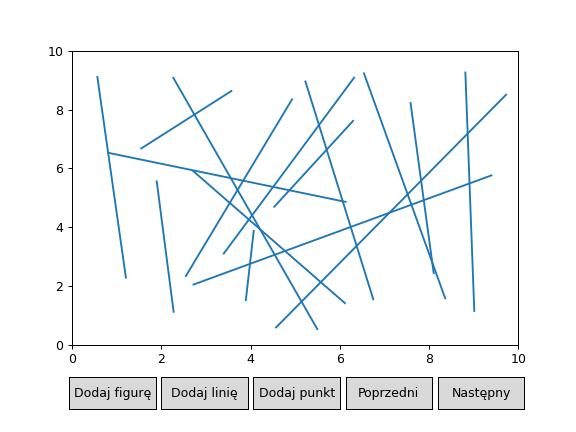

In [17]:
plot2 = Plot(xlim=[0,10], ylim=[0,10])
plot2.draw()

In [18]:
lines2 = getLinesFromPlot(plot2)


## Znajdowanie wszystkich przecięć

In [20]:

# UWAGA
# Wszystko jest zakomentowane w tej komórce, poniważ próbowałem zrobić to zadanie na własnym drzewie czerwono-czarnym, 
# ale coś nie wychodziło i po parunastu ciężkich godzinach poddałem się na razie i zrobiłem na zimportowanym SortedSecie
# def det(a, b, c):
#     a_x, a_y = a
#     b_x, b_y = b
#     c_x, c_y = c
#     first = (a_x - c_x) * (b_y - c_y)
#     second = (a_y - c_y) * (b_x - c_x)
#     determinant = first - second
#     return determinant


# def orientation(a, b, c, epsilon=10 ** (-12)):
#     determinant = det(a, b, c)

#     # -1 - po lewej stronie prostej
#     # 0 - na prostej
#     # 1 - po prawej stronie prostej

#     if determinant > epsilon:
#         return 1
#     elif determinant < -epsilon:
#         return -1
#     else:
#         return 0



     

# from functools import reduce
# class Point():
#     def __init__(self, x, y):
#         self.x = x
#         self.y = y

#     def lines(self, line1, line2):
#         self.line1 = line1
#         self.line2 = line2
        
#     def __eq__(self, other):
#         return self.x == other.x and self.y == other.y

#     def __gt__(self, other):
#         return self.x < other.x

#     def __hash__(self):
#         return self.x.__hash__() * self.y.__hash__()
    
#     def toTuple(self):
#         return self.x, self.y

# class Line:
#     def __init__(self, point1, point2):
#         if point1.x < point2.x:
#             self.point1 = point1
#             self.point2 = point2
#         else:
#             self.point1 = point2
#             self.point2 = point1
#         self.m = (self.point1.y - self.point2.y) / (self.point1.x - self.point2.x)
#         self.b = self.point1.y - self.m * self.point1.x
#         self.x = self.point1.x
    
#     def update_x(x):
#         Line.x = x
    
#     def __eq__(self, other):
#         return self.x == other.x and self.y == other.y
    
#     def toTuple(self):
#         return self.point1.toTuple(), self.point2.toTuple()

#     def __gt__(self, other):
#         return Line.x * self.m + self.b > Line.x * other.m + other.b

#     def __hash__(self):
#         return hash((self.point1, self.point2))

#     def __eq__(self, other):
#         return self.point1 == other.point1 and self.point2 == other.point2

#     # def computeY(self, x):
#     #     a = (self.point2.y - self.point1.y) / (self.point2.x - self.point1.x)
#     #     b = self.point2.y - a * self.point2.x
#     #     self.resultY = a * x + b

# # Q - events 
# # T - sorted_lines
# def convertLines(lineskk):
#     for i, line in enumerate(lineskk):
#         point1 = Point(line[0][0], line[0][1])
#         point2 = Point(line[1][0], line[1][1])
#         lineskk[i] = Line(point1, point2)
#     return lineskk
    
# class FindIntersection():
#     def __init__(self):
#         self.T = RBTree()
#         self.Q = RBTree()
#         self.scenes = []
#         self.lines = dict()
#         self.intersection = set()


        
#     def func1(self, a, b): # x.val , key
#         if a > b: return True
#         return False

#     def compareFunc1(self, a, b):
#         print(a,b)
#         if a == b: return True 
#         return False
    
#     def compareFunc2(self, a, b):
#         print(a,b)
#         if a == b: return True
#         return False
    
#     def func2(self, a, b):
#         if a > b : return True
#         return False

#     def findIntersection(self, lines):
#         for line in lines:
#             self.lines[line.point1] = line
#             self.lines[line.point2] = line
#             self.Q.insertNode(line.point1, self.func1)
#             self.Q.insertNode(line.point2, self.func1)

            
#         # for i in self.lines:
#         #     print(i.toTuple())
#         #     print(self.lines[i].toTuple())
#         min_y = reduce(lambda actual, point: point if point.y < actual.y else actual, self.lines.keys()).y
#         max_y = reduce(lambda actual, point: point if point.y > actual.y else actual, self.lines.keys()).y
#         Line.update_x(self.Q.treeMaximum(self.Q.root).val.x)
#         # Line.update_x(self.Q.treeMaximum(self.Q.root).val.x)
#         # broom = findMaxAndMin(S) # line that build broom - visualization

#         while self.Q.n > 0:
#             event = self.Q.treeMinimum(self.Q.root)
#             print("event", event.val.toTuple())
#             # self.Q.inorderTreeWalk(self.Q.root)
#             toDelete = self.Q.treeSearch(self.Q.root, event.val, self.func1, self.compareFunc1)
#             print("toDelete", toDelete, toDelete.val)
#             self.Q.deleteNode(toDelete)
            
#             self.scenes.append(Scene([PointsCollection([event.val.toTuple()], color="red"),
#                                       PointsCollection(list(map(lambda point: point.toTuple(), self.intersection)), color="red")],
#                                      [LinesCollection(list(map(lambda line: line.toTuple(), lines))),
#                                       LinesCollection([((event.val.x,min_y), (event.val.x, max_y))], color="red")]))
            
#             self.check(event.val)

#         return self.intersection



#     def check(self, event):
#         # print("check-T order")
#         # self.T.inorderTreeWalk(self.T.root)
#         # print("end Torder")
#         if event in self.lines:
#             line = self.lines[event]

#             Line.update_x(event.x)
#             # Pom = RBTree()
#             # for i in range(self.T.n):
#             #     Pom.insertNode(self.T.tab[i].val, self.func2)
#             # self.T = Pom
#             Pom = RBTree()
#             self.recur(self.T.root, Pom)
#             self.T = Pom

#             if event == line.point1:
#                 self.addLine(line)
#             else:
#                 self.removeLine(line)
#         else:
#             # print("drugi_else")
#             self.intersection.add(event)
#             line1 = event.line1
#             self.removeLine(line1)
#             line2 = event.line2
#             self.removeLine(line2)

#             Line.update_x(event.x + 10**(-12))
#             Pom = RBTree()
#             self.recur(self.T.root, Pom)
#             self.T = Pom
    
#             self.addLine(line1)
#             self.addLine(line2)
    
#     def findPoint(self, line1, line2):
#         a1 = (line1.point2.y - line1.point1.y) / (line1.point2.x - line1.point1.x)
#         b1 = line1.point1.y - a1 * line1.point1.x

#         a2 = (line2.point2.y - line2.point1.y) / (line2.point2.x - line2.point1.x)
#         b2 = line2.point1.y - a2 * line2.point1.x

#         x = (b2 - b1) / (a1 - a2)
#         y = a1 * (b2 - b1) / (a1 - a2) + b1

#         point = Point(x, y)
#         point.lines(line1, line2)
#         return point
    
#     def recur(self, nom, K):
#         if nom is not None:
#             K.insertNode(nom.val, self.compareFunc2)
#             self.recur(nom.left, K)
#             self.recur(nom.right, K)


#     # def lineIntersection(self, line1, line2, epsilon = 10e-12):
        
#     #     def direction(pi, pj, pk):
#     #         line1 = (pk[0]-pi[0], pk[1]-pi[1])
#     #         line2 = (pj[0]-pi[0], pj[1]-pi[1])

#     #         x1, y1 = line1
#     #         x2, y2 = line2

#     #         return (x1*y2) - (x2*y1)

#     #     def onSegment(pi, pj, pk): # edge case when any point is placed on line
#     #         xi, yi = pi
#     #         xj, yj = pj
#     #         xk, yk = pk

#     #         if min(xi, xj) <= xk <= max(xi, xj) and min(yi, yj) <= yk <= max(yi, yj):
#     #             return True
#     #         return False

#     #     p1 = line1.point1.toTuple()
#     #     p2 = line1.point2.toTuple()
#     #     p3 = line2.point1.toTuple()
#     #     p4 = line2.point2.toTuple()

#     #     d1 = direction(p3, p4, p1)
#     #     d2 = direction(p3, p4, p2)
#     #     d3 = direction(p1, p2, p3)
#     #     d4 = direction(p1, p2, p4)

#     #     if ((d1 > epsilon and d2 < -epsilon) or (d1 < -epsilon and d2 > epsilon)) and \
#     #         ((d3 > epsilon and d4 < -epsilon) or (d3 < -epsilon and d4 > epsilon)):
#     #         return self.findPoint(line1, line2)
#     #     elif (abs(d1) < epsilon) and onSegment(p3, p4, p1):
#     #         return self.findPoint(line1, line2)
#     #     elif (abs(d2) < epsilon) and onSegment(p3, p4, p2):
#     #         return self.findPoint(line1, line2)
#     #     elif (abs(d3) < epsilon) and onSegment(p1, p2, p3):
#     #         return self.findPoint(line1, line2)
#     #     elif (abs(d4) < epsilon) and onSegment(p1, p2, p4):
#     #         return self.findPoint(line1, line2)
#     #     else: return None

#     def lineIntersection(self, line1, line2):
#         orientation_11 = orientation(line1.point1.toTuple(), line1.point2.toTuple(), line2.point1.toTuple())
#         orientation_12 = orientation(line1.point1.toTuple(), line1.point2.toTuple(), line2.point2.toTuple())
#         orientation_21 = orientation(line2.point1.toTuple(), line2.point2.toTuple(), line1.point1.toTuple())
#         orientation_22 = orientation(line2.point1.toTuple(), line2.point2.toTuple(), line1.point2.toTuple())

#         if orientation_11 != orientation_12 and orientation_21 != orientation_22:
#             a_1 = (line1.point2.y - line1.point1.y) / (line1.point2.x - line1.point1.x)
#             b_1 = line1.point1.y - a_1 * line1.point1.x

#             a_2 = (line2.point2.y - line2.point1.y) / (line2.point2.x - line2.point1.x)
#             b_2 = line2.point1.y - a_2 * line2.point1.x

#             x = (b_2 - b_1) / (a_1 - a_2)
#             y = a_1 * (b_2 - b_1) / (a_1 - a_2) + b_1

#             point = Point(x, y)
#             point.lines(line1, line2)
#             return point
#         return None

#     def addLine(self, line):
#         # line.computeY(event.x)
#         # print("cos",line.point1.toTuple(), line.point2.toTuple())
#         self.T.insertNode(line, self.func2)
        
#         x = self.T.treeSearch(self.T.root, line, self.func2, self.compareFunc2)
#         # print(x)
#         x_succ = self.T.succRBTree(x)
#         x_pred = self.T.predRBTree(x)

#         if x_succ != None and x_pred != None:
#             intersection = self.lineIntersection(x_succ.val, x_pred.val)
#             if intersection is not None:
#                 # print("intersection", intersection)
#                 toCheck = self.Q.treeSearch(self.Q.root, intersection, self.func1, self.compareFunc1)
#                 if toCheck != self.Q.Nil :
#                     toDelete = self.Q.treeSearch(self.Q.root, intersection, self.func1, self.compareFunc1)
#                     # print("DAWAJ!!!!!!!!!!!!!!!!!!")
#                     self.Q.deleteNode(toDelete)

#         if x_pred != None:
#             intersection = self.lineIntersection(x_pred.val, line)
#             if intersection is not None:
#                 # print("intersection", intersection)
#                 toCheck = self.Q.treeSearch(self.Q.root, intersection, self.func1, self.compareFunc1)
#                 if toCheck == self.Q.Nil and  intersection not in self.intersection:
#                     self.Q.insertNode(intersection, self.func1)
                    
#         if x_succ != None:
#             intersection = self.lineIntersection(line, x_succ.val)
            
#             if intersection is not None:
#                 # print("intersection", intersection)
#                 toCheck = self.Q.treeSearch(self.Q.root, intersection, self.func1, self.compareFunc1)
#                 if toCheck == self.Q.Nil and intersection not in self.intersection:
#                     self.Q.insertNode(intersection, self.func1)
# # Q - events 
# # T - sorted_lines

#     def removeLine(self, line):
#         # print("-------------")
#         # self.T.inorderTreeWalk(self.T.root)
#         x = self.T.treeSearch(self.T.root, line, self.func2, self.compareFunc2)
#         # print("xval",x.val)
#         x_succ = self.T.succRBTree(x)
#         x_pred = self.T.predRBTree(x)

#         if x_succ != None and x_pred != None:
#             intersection = self.lineIntersection(x_succ.val, x_pred.val)
#             if intersection is not None and intersection not in self.intersection:
#                 self.Q.insertNode(intersection, self.func1)

#         self.T.deleteNode(x)

In [29]:
from sortedcontainers import SortedSet
class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def lines(self, line1, line2):
        self.line1 = line1
        self.line2 = line2
        
    def __eq__(self, other):
        return isinstance(other, Point) and self.x == other.x and self.y == other.y

    def __hash__(self):
        return self.x.__hash__()*self.y.__hash__()

    def __gt__(self, other):
        return isinstance(other, Point) and self.x > other.x

    def __ge__(self, other):
        return isinstance(other, Point) and self.x >= other.x

    def __le__(self, other):
        return isinstance(other, Point) and self.x <= other.x

    def __lt__(self, other):
        return isinstance(other, Point) and self.x < other.x
    
    def toTuple(self):
        return self.x, self.y

class Line():
    def __init__(self, point1, point2):
        if point1.x < point2.x:
            self.point1 = point1
            self.point2 = point2
        else:
            self.point1 = point2
            self.point2 = point1

    def toTuple(self):
        return self.point1.toTuple(), self.point2.toTuple()

    def computeY(self, x):
        a = (self.point2.y - self.point1.y) / (self.point2.x - self.point1.x)
        b = self.point2.y - a * self.point2.x
        return a * x + b

# Q - events 
# T - sorted_lines
def convertLines(lineskk):
    for i, line in enumerate(lineskk):
        point1 = Point(line[0][0], line[0][1])
        point2 = Point(line[1][0], line[1][1])
        lineskk[i] = Line(point1, point2)
    return lineskk
    
class FindIntersection():
    def __init__(self):
        self.T = SortedSet()
        self.Q = SortedSet(key=lambda point:-point.x)
        self.scenes = []
        self.lines = dict()
        self.intersection = set()

    def boundsBroom(self, lines):
        min_curr = (0,float('inf'))
        max_curr = (0,float('-inf'))
        for line in lines:
            p = max(line, key=lambda x : x[1])
            if p[1] > max_curr[1]:
                max_curr = p
                
            q = min(line, key=lambda x : x[1])
            if q[1] < min_curr[1]:
                min_curr = q

        return [list(min_curr), list(max_curr)]

    def update_keys(self, x):
        temp_lines = SortedSet(key=lambda l: l.computeY(x))
        temp_lines.update(self.T)
        self.T = temp_lines

    def convertToLines(self, lines):
        for idx, line in enumerate(lines):
            point_1 = Point(line[0][0], line[0][1])
            point_2 = Point(line[1][0], line[1][1])
            lines[idx] = Line(point_1, point_2)
        return lines

    def findIntersection(self, S):
        broom = self.boundsBroom(S)
        lines = self.convertToLines(S)

        for line in lines:
            self.lines[line.point1] = line
            self.lines[line.point2] = line
            self.Q.add(line.point1)
            self.Q.add(line.point2)
        
        self.update_keys(self.Q[0].x)

        while len(self.Q) > 0:
            event = self.Q.pop()
            self.scenes.append(Scene([PointsCollection([event.toTuple()], color="cyan"),
                                      PointsCollection(list(map(lambda point: point.toTuple(), self.intersection)), color="green")],
                                     [LinesCollection(list(map(lambda line: line.toTuple(), lines))),
                                      LinesCollection([((event.x, broom[0][1]), (event.x, broom[1][1]))], color="red")]))
            
            self.check(event)
        return self.intersection

    def check(self, event):

        if event in self.lines:
            line = self.lines[event]

            self.update_keys(event.x)

            if event == line.point1:
                self.addLine(line)
            else:
                self.removeLine(line)
        else:
            self.intersection.add(event)
            line1 = event.line1
            line2 = event.line2

            self.removeLine(line1)
            self.removeLine(line2)

            self.update_keys(event.x + 0.0001)

            self.addLine(line1)
            self.addLine(line2)
    
    def findPoint(self, line1, line2):
        a1 = (line1.point2.y - line1.point1.y) / (line1.point2.x - line1.point1.x)
        b1 = line1.point1.y - a1 * line1.point1.x

        a2 = (line2.point2.y - line2.point1.y) / (line2.point2.x - line2.point1.x)
        b2 = line2.point1.y - a2 * line2.point1.x

        x = (b2 - b1) / (a1 - a2)
        y = a1 * (b2 - b1) / (a1 - a2) + b1

        point = Point(x, y)
        point.lines(line1, line2)
        return point
    
    def lineIntersection(self, line1, line2, epsilon = 10e-12):
        
        def direction(pi, pj, pk):
            line1 = (pk[0]-pi[0], pk[1]-pi[1])
            line2 = (pj[0]-pi[0], pj[1]-pi[1])

            x1, y1 = line1
            x2, y2 = line2

            return (x1*y2) - (x2*y1)

        def onSegment(pi, pj, pk): # edge case when any point is placed on line
            xi, yi = pi
            xj, yj = pj
            xk, yk = pk

            if min(xi, xj) <= xk <= max(xi, xj) and min(yi, yj) <= yk <= max(yi, yj):
                return True
            return False

        p1 = line1.point1.toTuple()
        p2 = line1.point2.toTuple()
        p3 = line2.point1.toTuple()
        p4 = line2.point2.toTuple()

        d1 = direction(p3, p4, p1)
        d2 = direction(p3, p4, p2)
        d3 = direction(p1, p2, p3)
        d4 = direction(p1, p2, p4)

        if ((d1 > epsilon and d2 < -epsilon) or (d1 < -epsilon and d2 > epsilon)) and \
            ((d3 > epsilon and d4 < -epsilon) or (d3 < -epsilon and d4 > epsilon)):
            return self.findPoint(line1, line2)
        elif (abs(d1) < epsilon) and onSegment(p3, p4, p1):
            return self.findPoint(line1, line2)
        elif (abs(d2) < epsilon) and onSegment(p3, p4, p2):
            return self.findPoint(line1, line2)
        elif (abs(d3) < epsilon) and onSegment(p1, p2, p3):
            return self.findPoint(line1, line2)
        elif (abs(d4) < epsilon) and onSegment(p1, p2, p4):
            return self.findPoint(line1, line2)
        else: return None

    def addLine(self, line):

        self.T.add(line)
        i = self.T.index(line)
        
        if i - 1 >= 0 and i + 1 < len(self.T):
            intersection = self.lineIntersection(self.T[i - 1], self.T[i + 1])
            if intersection is not None and intersection in self.Q:
                self.Q.remove(intersection)
        if i - 1 >= 0:
            intersection = self.lineIntersection(self.T[i - 1], line)
            if intersection is not None and intersection not in self.intersection and intersection not in self.Q:
                self.Q.add(intersection)
        if i + 1 < len(self.T):
            intersection = self.lineIntersection(line, self.T[i + 1])
            if intersection is not None and intersection not in self.intersection and intersection not in self.Q:
                self.Q.add(intersection)

    def removeLine(self, line):
        i = self.T.index(line)

        if i - 1 >= 0 and i + 1 < len(self.T):
            intersection = self.lineIntersection(self.T[i - 1], self.T[i + 1])
            if intersection is not None and intersection not in self.intersection:
                self.Q.add(intersection)
        self.T.remove(line)

In [56]:
def showResult(result):
    print('Ilość znalezionych przecięć : ' + str(len(result)))
    for tmp in result:
        print('Linie przecinające się : ' + str(tmp.line1.toTuple()) + ' ' + str(tmp.line2.toTuple()))
        print('Dany punkt: ' + str(tmp.toTuple()), end = '\n\n')

In [60]:
lines3 = generateLines([-100, 100], 5)
lines4 = generateLines([-100, 100], 10)
lines5 = generateLines([-100, 100], 10)
lines6 = generateLines([-100, 100], 20)
lines7 = generateLines([-100, 100], 50)
lines8 = generateLines([-100, 100], 100)


Ilość znalezionych przecięć : 11
Linie przecinające się : ((-78.67431321572936, -48.65474790506714), (49.46308486169798, -22.639898667570947)) ((-91.55312463252581, 45.3406149611678), (42.003159574784746, -46.05234387002013))
Dany punkt: (17.324622564211015, -29.164748273841845)

Linie przecinające się : ((-91.55312463252581, 45.3406149611678), (42.003159574784746, -46.05234387002013)) ((-28.52108925376669, -13.495698078968417), (67.14542805805581, 24.70768794652507))
Dany punkt: (-14.029860558649075, -7.708783081124437)

Linie przecinające się : ((-28.52108925376669, -13.495698078968417), (67.14542805805581, 24.70768794652507)) ((42.473596592757275, 40.74342968902275), (70.09618004304278, -79.68551198644434))
Dany punkt: (47.91327144452133, 17.02753480773398)

Linie przecinające się : ((-40.59311971640367, -41.65413978684636), (49.127421762181285, 22.05433806081733)) ((-28.52108925376669, -13.495698078968417), (67.14542805805581, 24.70768794652507))
Dany punkt: (34.51076660007922, 11.

<IPython.core.display.Javascript object>


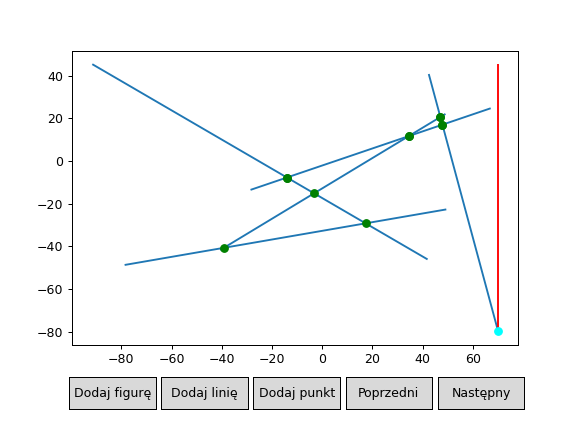

In [61]:
broom3 = FindIntersection()
points3 = broom3.findIntersection(lines3)
showResult(points3)
newPlot3 = Plot(broom3.scenes)
newPlot3.draw()

Ilość znalezionych przecięć : 11
Linie przecinające się : ((-63.767012165737704, 40.77139564983648), (-10.78278367936008, -26.882031363705508)) ((-95.4884097091182, -98.93071725440632), (19.99187541578449, 46.434994244756666))
Dany punkt: (-24.4195582162359, -9.46978328184748)

Linie przecinające się : ((-47.50148493482338, 98.57452541734176), (-7.8831497283863285, -24.746388159934398)) ((-95.4884097091182, -98.93071725440632), (19.99187541578449, 46.434994244756666))
Dany punkt: (-16.13944192724652, 0.9531646208433955)

Linie przecinające się : ((-95.4884097091182, -98.93071725440632), (19.99187541578449, 46.434994244756666)) ((-90.42039381353166, -42.22960250547649), (55.72924708781713, -34.27380341676462))
Dany punkt: (-48.63747013973487, -39.95510806240022)

Linie przecinające się : ((-95.4884097091182, -98.93071725440632), (19.99187541578449, 46.434994244756666)) ((-63.767012165737704, 40.77139564983648), (-10.78278367936008, -26.882031363705508))
Dany punkt: (-24.4195582162359, -

<IPython.core.display.Javascript object>


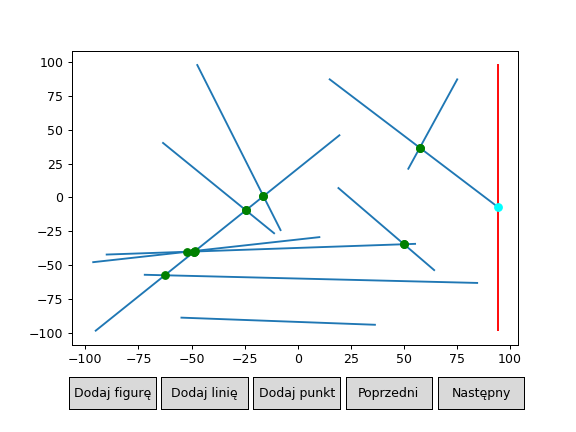

In [62]:
broom4 = FindIntersection()
points4 = broom4.findIntersection(lines4)
showResult(points4)
newPlot4 = Plot(broom4.scenes)
newPlot4.draw()

<IPython.core.display.Javascript object>


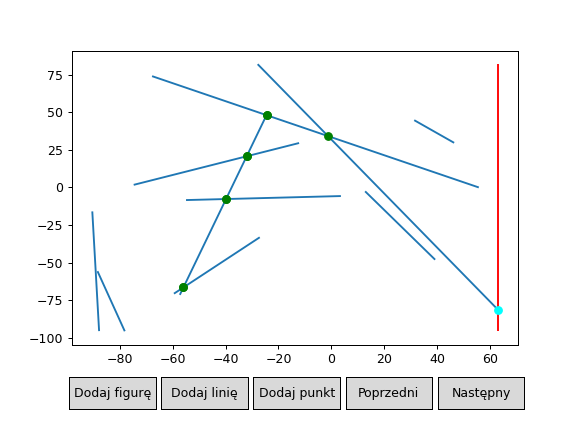

In [63]:
broom5 = FindIntersection()
points5 = broom5.findIntersection(lines5)
newPlot5 = Plot(broom5.scenes)
newPlot5.draw()

<IPython.core.display.Javascript object>


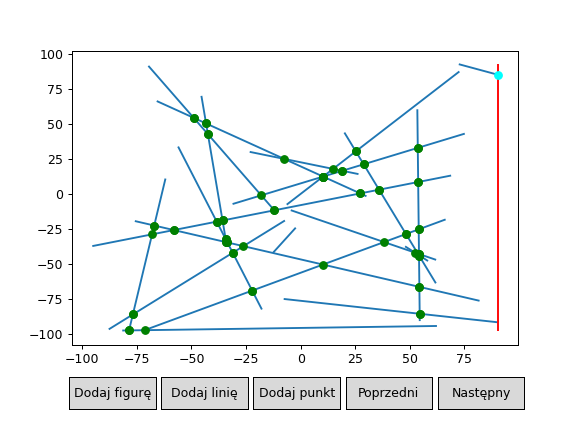

In [64]:
broom6 = FindIntersection()
pooints6 = broom6.findIntersection(lines6)
newPlot6 = Plot(broom6.scenes)
newPlot6.draw()

<IPython.core.display.Javascript object>


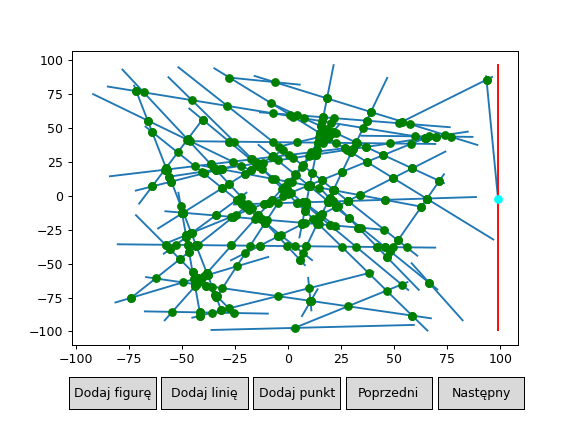

In [65]:
broom7 = FindIntersection()
points7 = broom7.findIntersection(lines7)
newPlot7 = Plot(broom7.scenes)
newPlot7.draw()

<IPython.core.display.Javascript object>


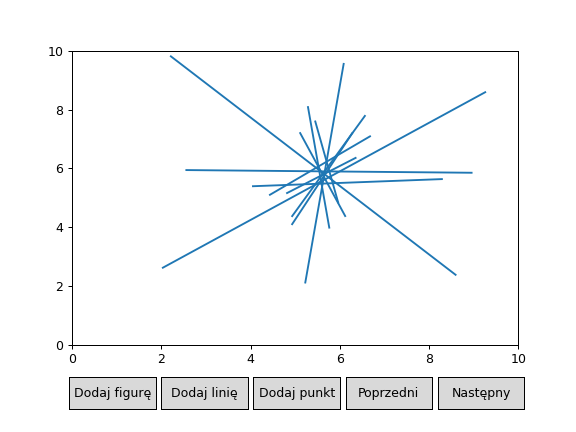

In [66]:
plot3 = Plot(xlim=[0,10], ylim=[0,10])
plot3.draw()

Ilość znalezionych przecięć : 11
Linie przecinające się : ((4.919984879032258, 4.3483631534326594), (6.57321068548387, 7.810372957354229)) ((5.444178427419354, 7.626549427942464), (5.96837197580645, 4.807921976962071))
Dany punkt: (5.736030511791333, 6.057239200512431)

Linie przecinające się : ((4.919984879032258, 4.3483631534326594), (6.57321068548387, 7.810372957354229)) ((5.28288810483871, 8.116745506373835), (5.766759072580644, 3.9500788397071696))
Dany punkt: (5.56391299175865, 5.696808980118785)

Linie przecinające się : ((4.03288810483871, 5.390029820099327), (8.307081653225804, 5.635127859315013)) ((5.101436491935484, 7.228265114216974), (6.129662298387096, 4.3483631534326594))
Dany punkt: (5.723145014561813, 5.486955392059031)

Linie przecinające się : ((2.1982106854838706, 9.83243178088364), (8.609501008064514, 2.356941584805209)) ((2.5409526209677415, 5.941500408334621), (8.972404233870966, 5.8495886436287385))
Dany punkt: (5.572389674483351, 5.898178193389486)

Linie przec

<IPython.core.display.Javascript object>


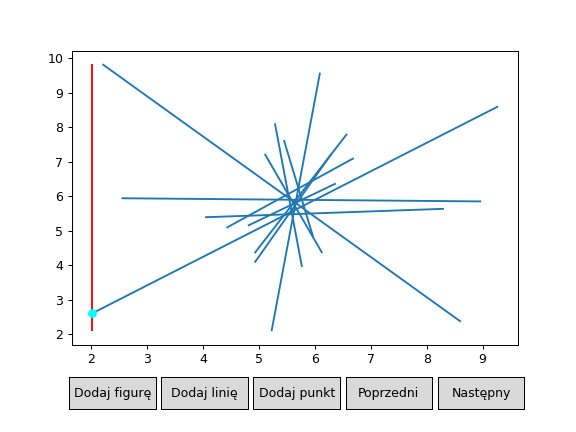

In [67]:
lines8 = getLinesFromPlot(plot3)
broom8 = FindIntersection()
points8 = broom8.findIntersection(lines8)
showResult(points8)
newPlot8 = Plot(broom8.scenes)
newPlot8.draw()

In [77]:
lines9 = generateLines([-100, 100], 10)

Ilość znalezionych przecięć : 11
Linie przecinające się : ((-25.371173116659023, 97.14922406070704), (83.39719954055545, -11.322973056852433)) ((42.49223775858064, -68.85048289208288), (45.341343542994764, 46.617406293819045))
Dany punkt: (44.85999184990212, 27.10929807912293)

Linie przecinające się : ((-56.8550530033277, 68.0812125881856), (73.537456201027, -32.153627168458044)) ((-96.18652366681053, -22.538447410612108), (95.01648502734503, 37.895683285539945))
Dany punkt: (15.221649177551239, 12.674680898814218)

Linie przecinające się : ((42.49223775858064, -68.85048289208288), (45.341343542994764, 46.617406293819045)) ((-56.8550530033277, 68.0812125881856), (73.537456201027, -32.153627168458044))
Dany punkt: (43.95875059059662, -9.41599572657924)

Linie przecinające się : ((61.37320118390804, -46.30590946109203), (85.03064752604018, 9.233255827474778)) ((-25.371173116659023, 97.14922406070704), (83.39719954055545, -11.322973056852433))
Dany punkt: (78.39812733809894, -6.337513294

<IPython.core.display.Javascript object>


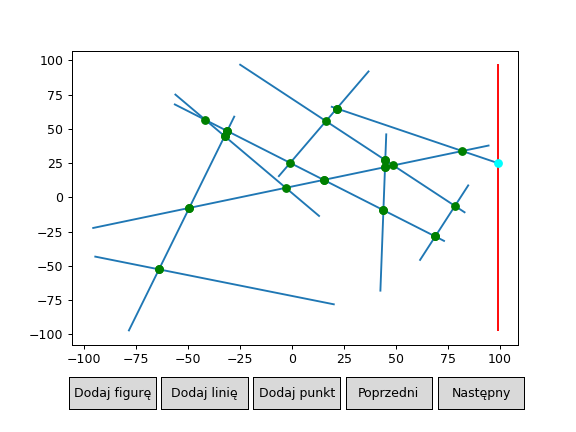

In [78]:

broom9 = FindIntersection()
points9 = broom9.findIntersection(lines9)
showResult(points9)
newPlot9 = Plot(broom9.scenes)
newPlot9.draw()